
**Regression models based on recurrent neural networks (RNN) can recognize patterns in time series data, making them an exciting technology for stock market forecasting. What distinguishes these RNNs from traditional neural networks is their architecture, consisting of multiple layers of long-term, short-term memory (LSTM). **


 The LSTM layers allow the model to learn patterns in a time series that occur over different periods and are often difficult for human analysts to detect. We can train such models with one feature (univariate models) or multiple features (multivariate models). 

Multivariate Models can take more data into account, and if we provide them with relevant features, they can make better predictions. 


Please refer to this website for more details.
https://www.relataly.com/stock-market-prediction-using-multivariate-time-series-in-python/1815/

In [ ]:
# install yahoo! finance
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# import libraries 
import yfinance as yf
import numpy as np
import pandas as pd
import tensorflow as tf
import math
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping # 
from sklearn.preprocessing import MinMaxScaler 
import pickle 
from tqdm.notebook import tnrange
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping # 
from datetime import date, timedelta, datetime
pd.set_option('display.max_rows', None)


In [ ]:
# download Google's stock price using Yahoo! Finance
data = yf.download("GOOGL" , start = "2018-01-01" , interval = '1d')

[*********************100%***********************]  1 of 1 completed


In [ ]:
# Data includes Google's stock price from 2018-01-02 to 2022-09-30
# There are 1196 rows and 6 columns in total
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,52.651001,53.799000,52.651001,53.660500,53.660500,31766000
2018-01-03,53.696499,54.805000,53.671501,54.576000,54.576000,31318000
2018-01-04,54.854500,55.203999,54.713001,54.787998,54.787998,26052000
2018-01-05,55.172501,55.679001,55.090000,55.514500,55.514500,30250000
2018-01-08,55.549999,55.958000,55.500000,55.710499,55.710499,24644000
...,...,...,...,...,...,...
2022-09-26,98.099998,99.879997,97.800003,98.169998,98.169998,27072700
2022-09-27,99.430000,100.000000,96.870003,97.500000,97.500000,30072800
2022-09-28,97.650002,100.699997,97.110001,100.050003,100.050003,32466300


In [ ]:
# Sort the data points based on indexes just for confirmation 
data.sort_index(inplace = True)

In [ ]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,52.651001,53.799000,52.651001,53.660500,53.660500,31766000
2018-01-03,53.696499,54.805000,53.671501,54.576000,54.576000,31318000
2018-01-04,54.854500,55.203999,54.713001,54.787998,54.787998,26052000
2018-01-05,55.172501,55.679001,55.090000,55.514500,55.514500,30250000
2018-01-08,55.549999,55.958000,55.500000,55.710499,55.710499,24644000


In [ ]:
# Check for missing values 
# This is no missing values in the data
data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

**Data Visualization**

In [ ]:
import plotly.graph_objects as go

In [ ]:
# Check the trend in Closing Values 
fig = go.Figure()

fig.add_trace(go.Scatter(x = data.index , y = data['Close'] , mode = 'lines'))
fig.update_layout(height = 500 , width = 900, 
                  xaxis_title='Date' , yaxis_title='Close')
fig.show()

In [ ]:
# Check the trend in Volume Traded
fig = go.Figure()
fig.add_trace(go.Scatter(x = data.index , y = data['Volume'] , mode = 'lines'))
fig.update_layout(height = 500 , width = 900, 
                  xaxis_title='Date' , yaxis_title='Volume')
fig.show()

**Data Preparation**

LSTM is sensitive to the scale of data. 

In [ ]:
# First, I only put stock close price into LSTM. Later, I will add more features into the model.
df = data[['Close']]
df.head

<bound method NDFrame.head of                  Close
Date                  
2018-01-02   53.660500
2018-01-03   54.576000
2018-01-04   54.787998
2018-01-05   55.514500
2018-01-08   55.710499
...                ...
2022-09-26   98.169998
2022-09-27   97.500000
2022-09-28  100.050003
2022-09-29   97.419998
2022-09-30   95.650002

[1196 rows x 1 columns]>

In [ ]:
# convert data to a numpy array
# We have to convert the data to numpy array to fit into LSTM. 
df = df.values
df.shape

(1196, 1)

In [ ]:
# get the number of rows to be used as training dataset
# We want to use 80% of data as the train data. 
train_data_len = math.ceil(len(df) * 0.8)
train_data_len

957

In [ ]:
# scale the data using MinMax Scaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)
scaled_data

array([[0.04400376],
       [0.05310371],
       [0.05521094],
       ...,
       [0.50510911],
       [0.47896722],
       [0.46137369]])

In [ ]:
# create the training dataset including 80% of the entire dataset 
train_data = scaled_data[0:train_data_len, :]
train_data.shape

(957, 1)

In [ ]:
# create the testing dataset
# create a new array containing scaled values
test_data = scaled_data[train_data_len-60: , :]
test_data.shape

(299, 1)

In [ ]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and one feature
# I choose 60 as time step, meaning we will use 60 days to make a single prediction
x_train =[]
y_train = []
for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i,0])
  

In [ ]:
# convert x_train and y_train to numpy array
x_train, y_train = np.array(x_train), np.array(y_train)


In [ ]:
# reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(897, 60, 1)

In [ ]:
y_train.shape

(897,)

In [ ]:
# Build the LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Dropout , LSTM , Bidirectional 


In [ ]:
model = Sequential()
model.add(LSTM(60, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(LSTM(60, return_sequences=False))
model.add(Dense(25, activation="relu"))
model.add(Dense(1))

In [ ]:
# compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [ ]:
# train the model
model.fit(x_train, y_train, batch_size=1, epochs=16)

Epoch 1/16
897/897 [==============================] - 8s 7ms/step - loss: 0.0042
Epoch 2/16
897/897 [==============================] - 6s 7ms/step - loss: 0.0015
Epoch 3/16
897/897 [==============================] - 7s 7ms/step - loss: 9.5935e-04
Epoch 4/16
897/897 [==============================] - 6s 6ms/step - loss: 8.3289e-04
Epoch 5/16
897/897 [==============================] - 5s 6ms/step - loss: 6.2136e-04
Epoch 6/16
897/897 [==============================] - 5s 6ms/step - loss: 7.1097e-04
Epoch 7/16
897/897 [==============================] - 5s 6ms/step - loss: 5.5624e-04
Epoch 8/16
897/897 [==============================] - 5s 6ms/step - loss: 4.0105e-04
Epoch 9/16
897/897 [==============================] - 5s 6ms/step - loss: 5.1522e-04
Epoch 10/16
897/897 [==============================] - 5s 6ms/step - loss: 3.6256e-04
Epoch 11/16
897/897 [==============================] - 5s 6ms/step - loss: 4.6556e-04
Epoch 12/16
897/897 [==============================] - 5s 6ms/step - lo

In [ ]:
# create the dataset x_test and y_test
x_test = []
y_test = df[train_data_len:,:]
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i,0])
   

In [ ]:
# convert data to numpy aray
x_test = np.array(x_test)

In [ ]:
# reshape 
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(239, 60, 1)

In [ ]:
# Get the predicted values
predictions = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler.inverse_transform(predictions)
y_test_unscaled = y_test

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

Median Absolute Error (MAE): 2.23
Mean Absolute Percentage Error (MAPE): 1.8 %
Median Absolute Percentage Error (MDAPE): 1.5 %


In [ ]:
# plot the data
train = data[:train_data_len]
valid = data[train_data_len:]
valid["Predictions"] = y_pred

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



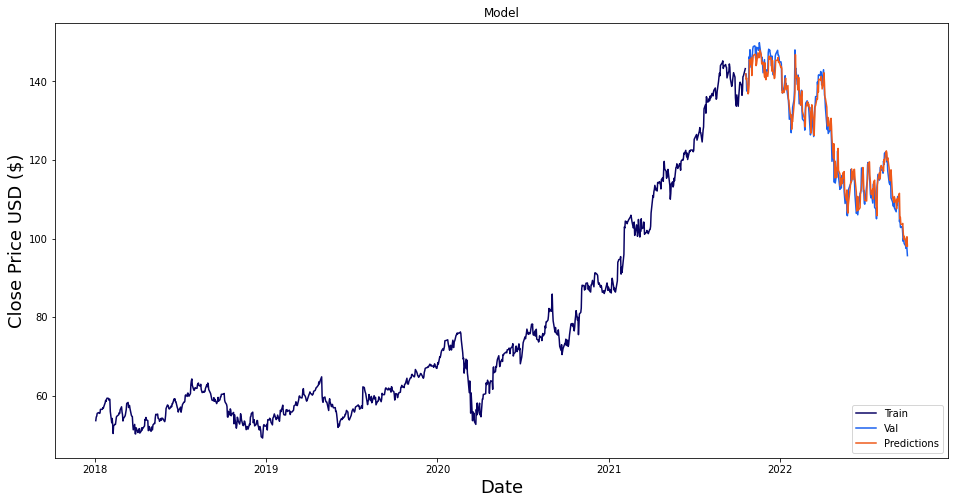

In [ ]:
# visualize the data
plt.figure(figsize=(16,8))
plt.title("Model")
plt.xlabel("Date", fontsize=18)
plt.ylabel("Close Price USD ($)", fontsize=18)
plt.plot(train["Close"])
plt.plot(valid[["Close","Predictions"]])
plt.legend(["Train", "Val","Predictions"], loc="lower right")
plt.show();


 **Multivariate Prediction Models**

This is a helful website which introduces multivariate LSTM.




https://www.relataly.com/stock-market-prediction-using-multivariate-time-series-in-python/1815/

In [ ]:
# I use the same Google stock price dataset.
data = yf.download("GOOGL" , start = "2018-01-01" , interval = '1d')

[*********************100%***********************]  1 of 1 completed


In [ ]:
# the data size is the same as before.
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,52.651001,53.799000,52.651001,53.660500,53.660500,31766000
2018-01-03,53.696499,54.805000,53.671501,54.576000,54.576000,31318000
2018-01-04,54.854500,55.203999,54.713001,54.787998,54.787998,26052000
2018-01-05,55.172501,55.679001,55.090000,55.514500,55.514500,30250000
2018-01-08,55.549999,55.958000,55.500000,55.710499,55.710499,24644000
...,...,...,...,...,...,...
2022-09-26,98.099998,99.879997,97.800003,98.169998,98.169998,27072700
2022-09-27,99.430000,100.000000,96.870003,97.500000,97.500000,30072800
2022-09-28,97.650002,100.699997,97.110001,100.050003,100.050003,32466300


In [ ]:
# Include five features 
FEATURES = ['High', 'Low', 'Open', 'Close', 'Volume']
data_filtered = data[FEATURES]


In [ ]:
# a new dataset is named as data_filtered
data_filtered.head()

,High,Low,Open,Close,Volume
Date,,,,,
2018-01-02,53.799000,52.651001,52.651001,53.660500,31766000
2018-01-03,54.805000,53.671501,53.696499,54.576000,31318000
2018-01-04,55.203999,54.713001,54.854500,54.787998,26052000
2018-01-05,55.679001,55.090000,55.172501,55.514500,30250000
2018-01-08,55.958000,55.500000,55.549999,55.710499,24644000


In [ ]:
# Convert the data to numpy values
np_data_unscaled = np.array(data_filtered)


In [ ]:
# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

In [ ]:
# Set the sequence length - this is the timeframe used to make a single prediction
# we use the same Timestamps like before. Use 60 days to predict the next day.

sequence_length = 60

In [ ]:
# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)
train_data_len

957

In [ ]:
# Create the training and test data
# All methods are the same as before
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]
print(train_data.shape)
print(test_data.shape)

(957, 5)
(299, 5)


In [ ]:
# get the column index of "Close"
index_Close = data.columns.get_loc("Close")

In [ ]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 5 features
# This time I wrote it into a def function. 
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

In [ ]:
# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

In [ ]:
# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
# This result is the same as univariate training, except for features becoming to 5. 
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(897, 60, 5) (897,)
(239, 60, 5) (239,)


In [ ]:
# Train the Multivariate Prediction Model

In [ ]:
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])

300 60 5


In [ ]:
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))


In [ ]:
model.compile(optimizer='adam', loss='mse')

In [ ]:
# Training the model
epochs = 16
batch_size = 1
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test)
                   )

Epoch 1/16
897/897 [==============================] - 16s 14ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 2/16
897/897 [==============================] - 12s 13ms/step - loss: 0.0012 - val_loss: 0.0035
Epoch 3/16
897/897 [==============================] - 12s 13ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 4/16
897/897 [==============================] - 12s 13ms/step - loss: 7.2157e-04 - val_loss: 0.0011
Epoch 5/16
897/897 [==============================] - 12s 13ms/step - loss: 4.8210e-04 - val_loss: 0.0053
Epoch 6/16
897/897 [==============================] - 12s 13ms/step - loss: 5.6327e-04 - val_loss: 0.0010
Epoch 7/16
897/897 [==============================] - 11s 13ms/step - loss: 0.0011 - val_loss: 0.0032
Epoch 8/16
897/897 [==============================] - 12s 13ms/step - loss: 4.9031e-04 - val_loss: 9.2848e-04
Epoch 9/16
897/897 [==============================] - 12s 13ms/step - loss: 7.3148e-04 - val_loss: 0.0023
Epoch 10/16
897/897 [==============================] - 12s

In [ ]:
# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

In [ ]:
# Get the predicted values
predictions = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(predictions)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

Median Absolute Error (MAE): 2.77
Mean Absolute Percentage Error (MAPE): 2.16 %
Median Absolute Percentage Error (MDAPE): 1.89 %


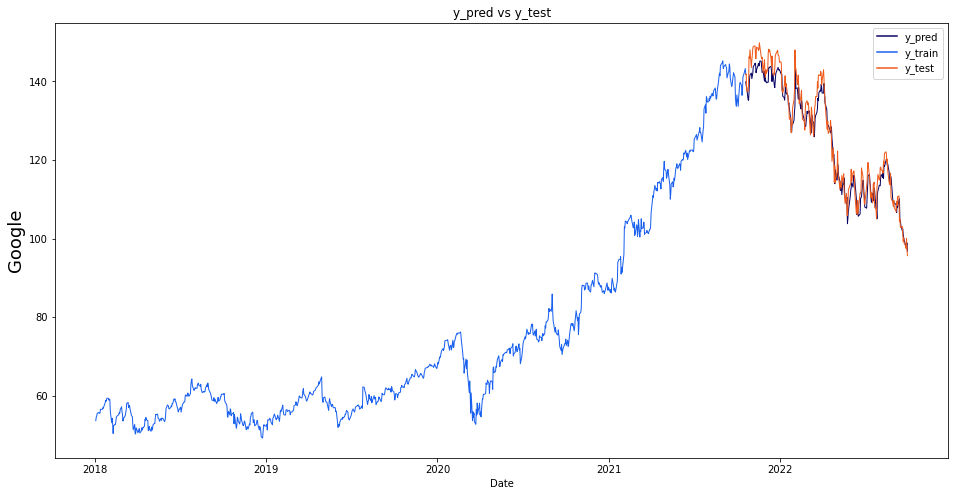

In [ ]:
# The date from which on the date is displayed
display_start_date = "2018-01-01" 
import seaborn as sns 
# Add the difference between the valid and predicted prices
train = pd.DataFrame(data_filtered['Close'][:train_data_len + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(data_filtered['Close'][train_data_len:]).rename(columns={'Close': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
df_union = pd.concat([train, valid])

# Zoom in to a closer timeframe
df_union_zoom = df_union[df_union.index > display_start_date]

# Create the lineplot
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("y_pred vs y_test")
plt.ylabel("Google", fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1);


**Predict Next Day’s Price**

In [ ]:
stockname = 'Google'
symbol = 'GOOGL'
df = yf.download(symbol , start = "2018-01-01" , interval = '1d')
end_date =  date.today().strftime("%Y-%m-%d")
start_date = '2018-01-01'

df_temp = df[-sequence_length:]
new_df = df_temp.filter(FEATURES)

N = sequence_length

# Get the last N day closing price values and scale the data to be values between 0 and 1
last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

# Create an empty list and Append past N days
X_test_new = []
X_test_new.append(last_N_days_scaled)

# Convert the X_test data set to a numpy array and reshape the data
pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

# Print last price and predicted price for the next day
price_today = np.round(new_df['Close'][-1], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

plus = '+'; minus = ''
print(f'The close price for {stockname} at {end_date} was {price_today}')
print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')

[*********************100%***********************]  1 of 1 completed
The close price for Google at 2022-10-01 was 95.65
The predicted close price is 96.13999938964844 (+0.51%)


[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Figure size 2520x2520 with 0 Axes>

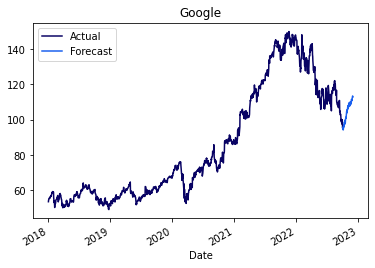

In [ ]:
# download the data
df = yf.download(symbol , start = "2018-01-01" , interval = '1d')
y = df['Close']
y = y.values.reshape(-1, 1)

# scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(y)
y = scaler.transform(y)

# generate the input and output sequences
n_lookback = 60  # length of input sequences (lookback period)
n_forecast = 60  # length of output sequences (forecast period)

X = []
Y = []

for i in range(n_lookback, len(y) - n_forecast + 1):
    X.append(y[i - n_lookback: i])
    Y.append(y[i: i + n_forecast])

X = np.array(X)
Y = np.array(Y)

# fit the model
model = Sequential()
model.add(LSTM(60, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(60, return_sequences=False))
model.add(Dense(25, activation="relu"))
model.add(Dense(n_forecast))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X, Y, epochs=15, batch_size=1, verbose=0)

# generate the forecasts
X_ = y[- n_lookback:]  # last available input sequence
X_ = X_.reshape(1, n_lookback, 1)

Y_ = model.predict(X_).reshape(-1, 1)
Y_ = scaler.inverse_transform(Y_)

# organize the results in a data frame
df_past = df[['Close']].reset_index()
df_past.rename(columns={'index': 'Date', 'Close': 'Actual'}, inplace=True)
df_past['Date'] = pd.to_datetime(df_past['Date'])
df_past['Forecast'] = np.nan
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]

df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_future['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n_forecast)
df_future['Forecast'] = Y_.flatten()
df_future['Actual'] = np.nan

results = df_past.append(df_future).set_index('Date')

# plot the results
plt.figure(figsize=(35,35))
results.plot(title="Google")


In [ ]:
# Check the trend in Closing Values 
fig = go.Figure()

fig.add_trace(go.Scatter(x = results.index , y = results['Actual'] , mode = 'lines'))
fig.add_trace(go.Scatter(x = results.index , y = results['Forecast'] , mode = 'lines'))

fig.update_layout(height = 500 , width = 900, showlegend=False,
                  xaxis_title='Date' , yaxis_title='Stock Close Price')
fig.show()